- 위음성비용(긍정을 부정으로 분류할때 비용)을 위양성 비용(부정을 긍정으로 분류할때 비용)보다 크게 설정
- 위음성 비용 = w * 위양성비용(w > 1)로 설정한 모델 
=> 가능하면 긍정으로 분류

### 확률모델
- 로지스틱 회귀, 나이브 베이즈 등의 확률 모델들은 cut-off value, c를 조정하는 방식으로 구현
- .predict_proba
- class_weight : 여러 모델에서 class_weight라는 파라미터를 사전으로 입력해 비용민감 모델로 사용
- ex) SVC(class_weight = {1:10, -1:1}) -> 클래스 1에 -1보다 10배의 가중치

### cut-off value 조정

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('./데이터/Secom.csv')
x = df.drop('Y', axis = 1)
y = df['Y']
train_x, test_x, train_y, test_y = train_test_split(x,y)

In [4]:
# 특징이 매우 많음을 확인
train_x.shape

(1175, 590)

In [5]:
# 클래스 불균형 확인
train_y.value_counts()

-1    1099
 1      76
Name: Y, dtype: int64

In [6]:
# 클래스 불균형 비율 계산
train_y.value_counts().iloc[0] / train_y.value_counts().iloc[-1]

14.460526315789474

In [7]:
# KNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
KNN_model = KNN(n_neighbors = 11).fit(train_x, train_y)
pred_y = KNN_model.predict(test_x)
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

# 재현율이 0% 불균형이 심각한 수준

0.0
0.9285714285714286


In [9]:
# 비용 민감 모델 적용한 Logistic Regression 모델 테스트
from sklearn.linear_model import LogisticRegression as LR
# 간단한 모델이므로 max를 크게 잡아도 과적합 위험이 적다
model = LR(max_iter = 100000).fit(train_x, train_y)
pred_y = model.predict(test_x)
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

0.14285714285714285
0.8826530612244898


c:\users\82106\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# out off value를 조정
probs = model.predict_proba(test_x)
probs = pd.DataFrame(probs, columns = model.classes_) # 어떤 클래스를 바탕으로 했는지 저장

cut_off_value = 0.3

pred_y = 2*(probs.iloc[:,-1] >= cut_off_value) - 1
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

0.14285714285714285
0.8647959183673469


In [11]:
# out off value를 조정하는 함수 작성
def cost_sensitive_model(model, cut_off_value, test_x, test_y):
    probs = model.predict_proba(test_x)
    probs = pd.DataFrame(probs, columns = model.classes_)
    pred_y = 2*(probs.iloc[:,-1] >= cut_off_value) - 1
    recall = recall_score(test_y, pred_y)
    accuracy = accuracy_score(test_y, pred_y)
    return recall, accuracy

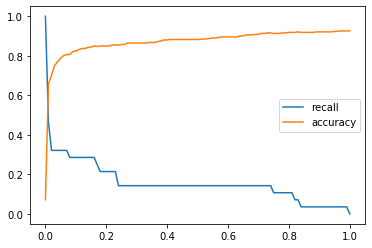

In [13]:
# out off value에 따른 recall과 accuracy 변화 확인
from matplotlib import pyplot as plt
import numpy as np

cut_off_value_list = np.linspace(0,1,101)
recall_list = []
accuracy_list = []

for c in cut_off_value_list:
    recall, accuracy = cost_sensitive_model(model, c, test_x, test_y)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    
plt.plot(cut_off_value_list, recall_list, label='recall')
plt.plot(cut_off_value_list, accuracy_list, label='accuracy')
plt.legend()

### class weight 조정

In [15]:
df = pd.read_csv('./데이터/page-blocks0.csv')
x = df.drop('Class', axis = 1)
y = df['Class']
train_x, test_x, train_y, test_y = train_test_split(x,y)

# 클래스 불균형 확인 -> 오버/언더샘플링 적용하기엔 부적절
train_y.value_counts()

negative    3673
positive     431
Name: Class, dtype: int64

In [16]:
train_y.replace({'negative': -1, 'positive':1}, inplace = True)
test_y.replace({'negative': -1, 'positive':1}, inplace = True)

# 클래스 불균형 비율 계산
train_y.value_counts().iloc[0] / train_y.value_counts().iloc[-1]

8.522041763341067

In [17]:
# KNN을 사용한 클래스 불균형 테스트
KNN_model = KNN(n_neighbors = 11).fit(train_x, train_y)
pred_y = KNN_model.predict(test_x)
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

# 불균형이 심각한 수준은 아님

0.640625
0.9532163742690059


In [19]:
from sklearn.svm import SVC
model = SVC().fit(train_x, train_y)
pred_y = model.predict(test_x)
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

0.0546875
0.9115497076023392


In [20]:
# 클래스 웨이트 조정
model = SVC(class_weight = {1:8, -1:1}).fit(train_x, train_y)
pred_y = model.predict(test_x)
print(recall_score(test_y, pred_y))
print(accuracy_score(test_y, pred_y))

0.8984375
0.6191520467836257
